# Sunspot Prediction using Kernel Filters


---
Name: Aaryan Kumar

Duration of Project: March 2022 - April 2022

---

##Importing Libraries

In [1]:
import math
import time
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

##Defining Filter Functions

In [2]:
# Gaussian kernel
def Kernel(x, kernel_size) :
    return np.exp(-x**2 / kernel_size**2)

In [3]:
# Vector quantization algorithm
def QV(C, err, threshold, embedding_size, sample, current_error) :
    # compute minimum distance
    minimum = 1e100
    min_index = 0
    if (len(C) != 0) :
        min_index = np.argmin(abs(sample[embedding_size-1] - np.array(C)[:,embedding_size-1]))
        minimum = abs(sample[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
    # update codebook
    if (minimum > threshold) :
        C.append(sample)
        err.append(current_error)
    else :
        err[min_index] += current_error
    return C, err

In [4]:
# QKLMS filter with MSE cost function
def QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * np.array(err[0:i]).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size)
        # update error
        e[i] = d[i] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e, y, growth, step_size*np.array(err)

In [5]:
# QKLMS filter with MCC cost function
def QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    a = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    err = []
    for i in range(epochs) :
        # compute output
        y[i] = 0
        x_vect = np.array(x[i:(i+embedding_size)])
        if (i != 0) :
            y[i] = step_size * (np.array(err[0:i]) * Kernel(np.array(err[0:i]), entropy_kernel_size)).T @ Kernel(np.linalg.norm(x_vect - np.array(C), 2, axis=1), kernel_size) / entropy_kernel_size**2
        # update error
        e[i] = d[i] - y[i]
        # compute QV
        C, err = QV(C, err, threshold, embedding_size, x_vect, e[i])
        # update growth
        growth[i] = len(C)
    # return weights and learning curve
    return e, y, growth, step_size*np.array(err)

In [6]:
# Q-KRLS filter with MSE cost function
def QKRLS_MSE(x, d, regularizer, kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer + Kernel(0, kernel_size)])**-1
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # compute vectors
            z = np.array(Q@h)
            r = regularizer + Kernel(0, kernel_size) - z.T@h
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e, y, growth, np.array(a)

In [7]:
# Q-KRLS filter with MCC cost function
def QKRLS_MCC(x, d, regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold) :
    # calculate epochs
    epochs = np.size(x)
    # initialize vectors
    x = np.concatenate((np.zeros(embedding_size), x))
    e = np.zeros(epochs)
    y = np.zeros(epochs)
    growth = np.zeros(epochs)
    C = []
    a = []
    Q = 0
    # iterate through samples
    for i in range(epochs) :
        # run QKRLS
        x_vect = x[i:(i+embedding_size)]
        if (i == 0) :
            Q = np.array([regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size)**-1])
            a = np.array([Q*d[0]])
            y[0] = 0
            C.append(x_vect)
        else :
            # compute QV
            minimum = 1e100
            min_index = 0
            if (len(C) != 0) :
                min_index = np.argmin(abs(x_vect[embedding_size-1] - np.array(C)[:,embedding_size-1]))
                minimum = abs(x_vect[embedding_size-1] - np.array(C)[min_index,embedding_size-1])
            # update codebook
            if (minimum > threshold) :
                C.append(x_vect)
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C)-1)]), 2, axis=1), kernel_size)]).T
                quantized = 1
            else :
                h = np.array([Kernel(np.linalg.norm(x_vect - np.array(C[0:(len(C))]), 2, axis=1), kernel_size)]).T
                quantized = 0
            # update error
            y[i] = h.T@np.array(a)
            e[i] = d[i] - y[i]
            # compute output if quantized
            if (quantized == 1) :
                # compute vectors
                z = np.array(Q@h)
                phi = Kernel(e[i], entropy_kernel_size)**-1
                r = regularizer*(entropy_kernel_size**2)*forgetting_factor + Kernel(0, kernel_size) - z.T@h
                # update Q matrix
                Q_dim = len(z) + 1
                Q_t = np.zeros((Q_dim, Q_dim))
                Q_t[0:(Q_dim-1), 0:(Q_dim-1)] = r*Q + z@z.T
                Q_t[0:(Q_dim-1), (Q_dim-1):Q_dim] = -z
                Q_t[(Q_dim-1):Q_dim, 0:(Q_dim-1)] = -z.T
                Q_t[(Q_dim-1):Q_dim, (Q_dim-1):Q_dim] = 1
                Q = Q_t / r
                # update weights
                a_t = np.zeros((Q_dim,1))
                a_t[0:(Q_dim-1)] = a - z*e[i] / r
                a_t[(Q_dim-1):Q_dim] = e[i] / r
                a = a_t
            else :
                a[min_index] += e[i]
        # update growth curve
        growth[i] = len(C)
    return e, y, growth, a

##Loading Data

In [8]:
data = np.loadtxt("sun_spot_input.asc")
data = (data-min(data))/(max(data)-min(data))

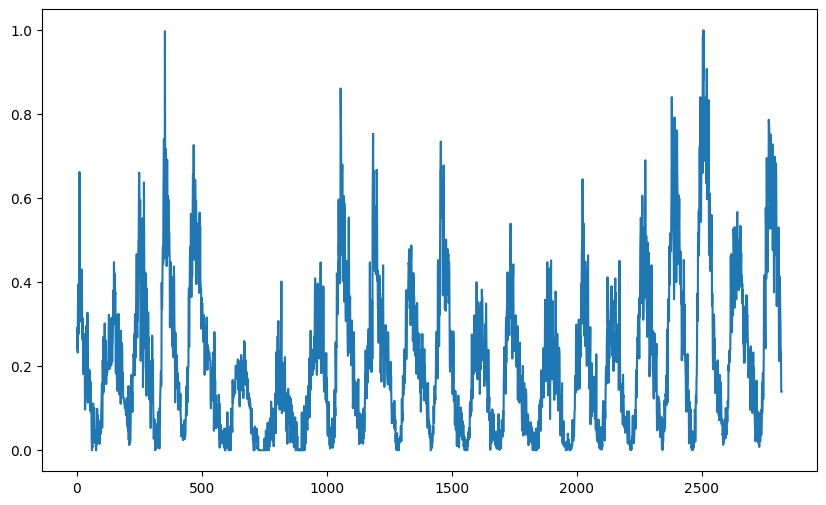

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(data)

## Predicting Using QKLMS with MSE

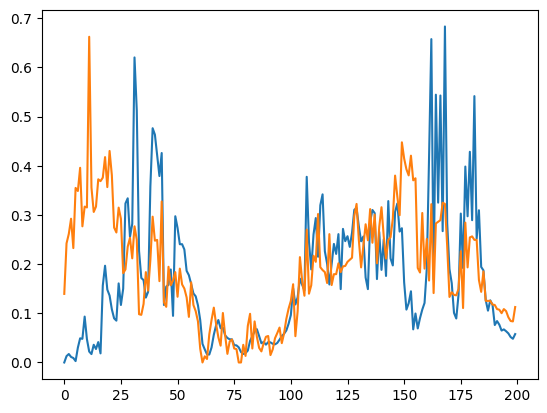

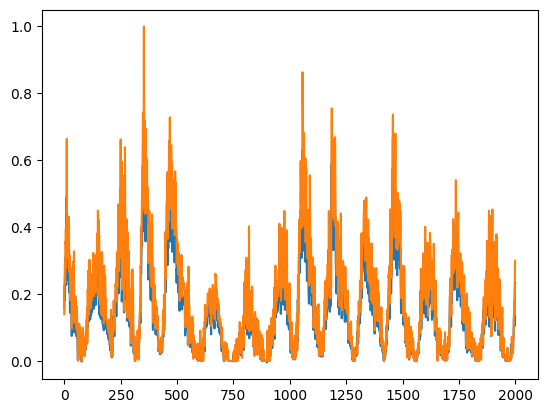

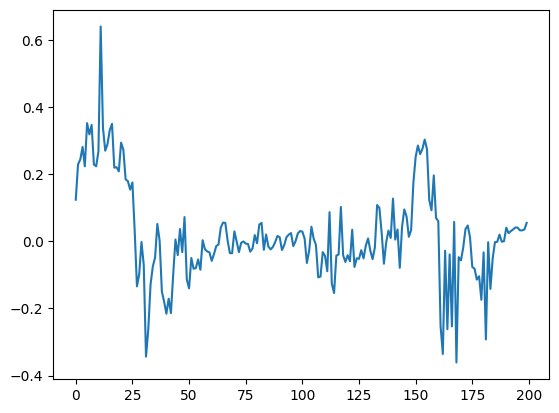

In [18]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.3
entropy_kernel_size = 1
threshold = 0.3
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKLMS_MSE(x, d, kernel_size, embedding_size, step_size, threshold)

x = data
d = np.roll(x, 1)

plt.plot(y)
plt.plot(d[0:200])
plt.show()

c = np.convolve(x, a.reshape(-1), mode='same')
plt.plot(c[0:2000])
plt.plot(d[0:2000])
plt.show()

plt.plot(J)
plt.show()

##Predicting using QKLMS with MCC

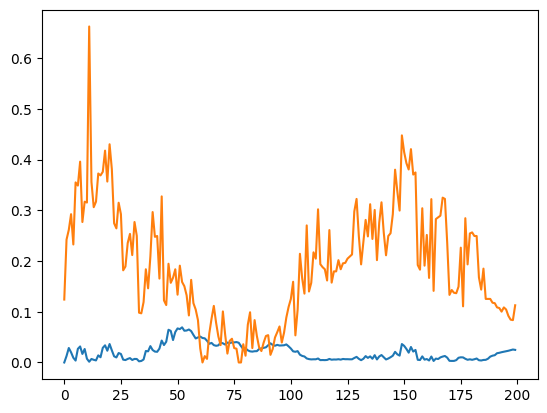

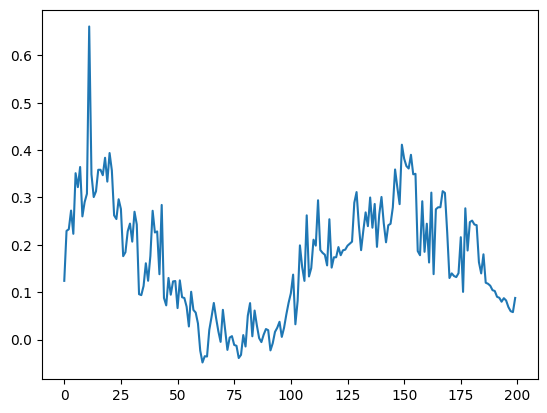

In [20]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.3
entropy_kernel_size = 1
threshold = 0.1
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKLMS_MCC(x, d, kernel_size, entropy_kernel_size, embedding_size, step_size, threshold)
plt.plot(y)
plt.plot(d[0:200])
plt.show()

plt.plot(J)
plt.show()

##Predicting using QKRLS with MSE

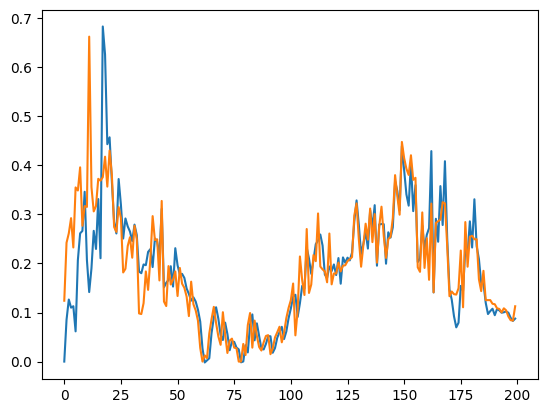

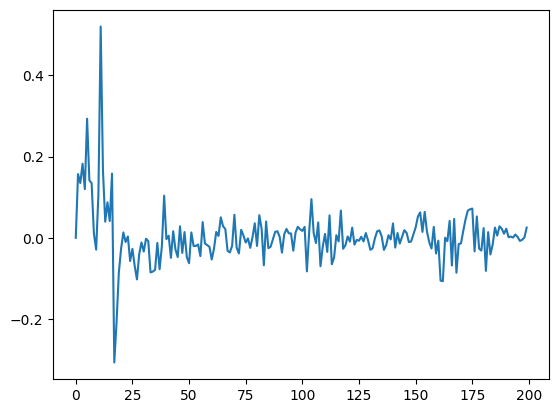

In [21]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.4
entropy_kernel_size = 1
threshold = 0.3
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKRLS_MSE(x[0:200], d[0:200], regularizer, kernel_size, embedding_size, threshold)
plt.plot(y)
plt.plot(d[0:200])
plt.show()

plt.plot(J)
plt.show()

##Predicting using QKRLS with MCC

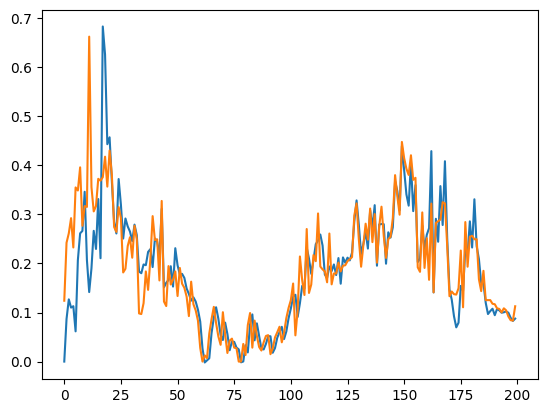

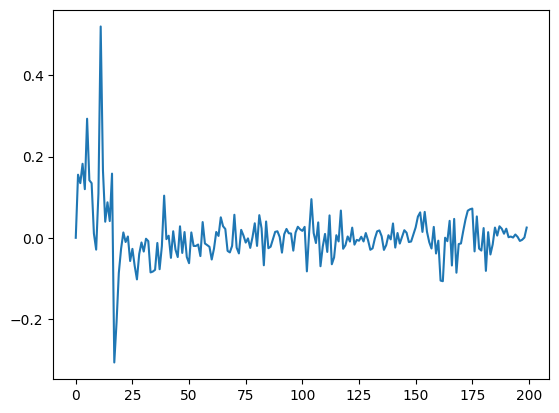

In [22]:
x = data[0:200]
d = np.roll(x, 1)[0:200]

regularizer = 0.01
embedding_size = 6
kernel_size = 0.4
entropy_kernel_size = 1
threshold = 0.3
forgetting_factor = 0.98
step_size = 0.2

J, y, growth, a = QKRLS_MCC(x[0:200], d[0:200], regularizer, forgetting_factor, kernel_size, entropy_kernel_size, embedding_size, threshold)
plt.plot(y)
plt.plot(d[0:200])
plt.show()

plt.plot(J)
plt.show()